# Mice sleep

## Data reading

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder



In [174]:
# The file is made up of the following structure:
# state : char (1 byte)
# bin : array[0..400] of single (array of 401 floats (4 bytes each))
# EEGv,EMGv,temp : single (4 bytes each)
# Make a pandas dataframe with the data with appropriate column names
# Create a dtype with the binary data format and the desired column names

# Read all the .smo files in the data folder
train_files = glob.glob('data/*.smo')
test_files = glob.glob('data/test/*.smo')

state_mapping = {
    b'w': 'w', b'1': 'w', b'4': 'w',
    b'n': 'n', b'2': 'n', b'5': 'n',
    b'r': 'r', b'3': 'r', b'6': 'r'
}


def fix_state(dataframe):
    dataframe['state'] = dataframe['state'].map(state_mapping)
    # Change state to 'x' if it is not one of the 3 states
    dataframe['state'] = dataframe['state'].fillna('x')
    return dataframe

def load_file(file_path):
    dt = [('state', 'a1')]
    for i in range(401):
        dt.append(('bin' + str(i), 'f4'))
    dt.append(('EEGv', 'f4'))
    dt.append(('EMGv', 'f4'))
    dt.append(('temp', 'f4'))
    dt = np.dtype(dt)
    data = np.fromfile(file_path, dtype=dt)
    #data = np.fromfile(files[0], dtype=dt)
    df = pd.DataFrame.from_records(data)
    fix_state(df)
    # Keep only the first 2 out of 4 days of data
    df = df[:int(len(df)/2)]
    return df

def load_files(files):
    dt = [('state', 'a1')]
    for i in range(401):
        dt.append(('bin' + str(i), 'f4'))
    dt.append(('EEGv', 'f4'))
    dt.append(('EMGv', 'f4'))
    dt.append(('temp', 'f4'))
    dt = np.dtype(dt)
    data = np.concatenate( [np.fromfile(file, dtype=dt) for file in files] )
    #data = np.fromfile(files[0], dtype=dt)
    df = pd.DataFrame.from_records(data)
    fix_state(df)
    # Keep only the first 2 out of 4 days of data
    df = df[:int(len(df)/2)]
    return df


## Separation, Normalization/preprocessing, Feature Selection

# Data Visualization

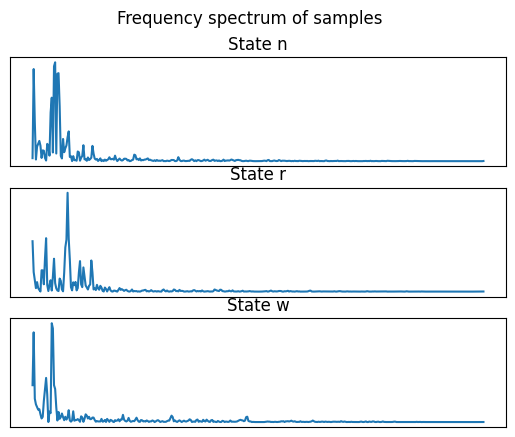

In [175]:
df = load_file(train_files[4])

states = df['state'].unique()
# Pick a sample for each possible state
samples = []
for i in states:
    samples.append(df[df['state'] == i].sample(1))

# Plot the samples frequency spectrum in a grid
# Disable axis numbers and ticks
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
fig, axs = plt.subplots(3, 1)
fig.suptitle('Frequency spectrum of samples')
from itertools import product

subplot_indices = list(product(range(3), range(1)))
for i, sample in enumerate(samples):
    subplot_index = subplot_indices[i]
    axs[subplot_index[0]].plot(sample.iloc[:, 1:401].mean())
    axs[subplot_index[0]].set_title('State ' + str(sample['state'].iloc[0]))
plt.show()




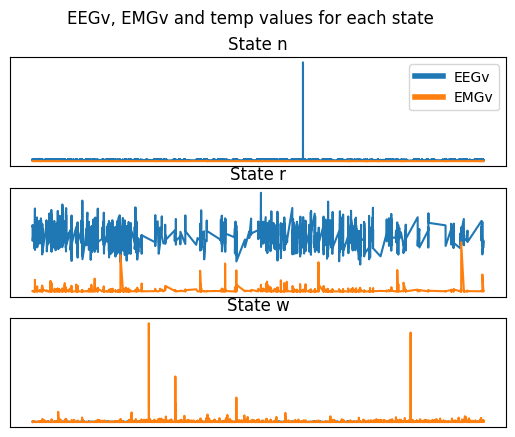

In [176]:
# Plot the possible values for EEGv, EMGv and temp values for each state

# Disable axis numbers and ticks
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
fig, axs = plt.subplots(3, 1)
fig.suptitle('EEGv, EMGv and temp values for each state')
from itertools import product

subplot_indices = list(product(range(3), range(1)))
for i, state in enumerate(states):
    subplot_index = subplot_indices[i]
    axs[subplot_index[0]].plot(df[df['state'] == state]['EEGv'])
    axs[subplot_index[0]].plot(df[df['state'] == state]['EMGv'])
    # Temp is always at 0
    # axs[subplot_index[0], subplot_index[1]].plot(df[df['state'] == state]['temp'])
    axs[subplot_index[0]].set_title('State ' + str(state))

# Add a legend for the colors
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='tab:blue', lw=4),
                Line2D([0], [0], color='tab:orange', lw=4)]
axs[0].legend(custom_lines, ['EEGv', 'EMGv'])


plt.show()




# Normalization

In [177]:
one_hot_mapping = {'w': np.array([0,0,0,1]),
                 'n': np.array([0,0,1,0]),
                 'r': np.array([0,1,0,0]),
                 'x': np.array([1,0,0,0])}

def normalize(df):
    normalized_df = df.copy()
    # EEGv
    min_value = df['EEGv'].min()
    max_value = df['EEGv'].max()
    normalized_df['EEGv'] = (df['EEGv'] - min_value) / (max_value - min_value)

    # EMGv
    min_value = df['EMGv'].min()
    max_value = df['EMGv'].max()
    normalized_df['EMGv'] = (df['EMGv'] - min_value) / (max_value - min_value)

    for i in range(401):
        min_value = df['bin' + str(i)].min()
        max_value = df['bin' + str(i)].max()
        normalized_df['bin' + str(i)] = (df['bin' + str(i)] - min_value) / (max_value - min_value)


    # Drop temp column and upper half of bin columns
    normalized_df = normalized_df.drop(['temp'], axis=1)
    normalized_df = normalized_df.drop(normalized_df.iloc[:, 201:401], axis=1)

    # State
    normalized_df['state'] = df['state'].map(one_hot_mapping)

    return normalized_df

def split_data(data):
    return (data.drop('state', axis=1), data['state'])


## Model building

### Model Neural Network

In [178]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from keras.optimizers import RMSprop


def build_model(class_num=4, input_dim=203):
  model = Sequential()
  optimizer = RMSprop(learning_rate=0.015)
  model.add(Dense(40, input_dim=input_dim, activation='relu'))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(15, activation='relu'))
  model.add(Dense(class_num, activation='tanh'))
  model.add(Dropout(0.2))

  # Compile the model
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

def save_model(model, model_name):
  model.save(model_name)
  print('Model saved as ' + model_name)

def load_model(model_name):
  model = tf.keras.models.load_model(model_name)
  print('Model loaded from ' + model_name)
  return model

def train_model(model, X_train, y_train, epochs=100, batch_size=10):
  model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

def predict(model, X_test):
  y_pred = model.predict(X_test)
  return y_pred

## Execution

In [179]:
# Get the list of all the files
# Shuffle it
# Pick out 20 files at a time
# Load, normalize, train
# Save the model
# Repeat until all files are used
import random

# Shuffle train_files
training_files = train_files
random.shuffle(training_files)

model = build_model()
save_model(model, 'models/model' + str(0) + '.h5')

# Pick out 20 files at a time
for i in range(0, len(training_files), 20):
  print("Training with files from " + str(i) + " to " + str(i+20))
  start = i
  end = i+20
  if end > len(training_files):
    end = len(training_files) - 1
  data = load_files(training_files[start:end])
  print("\tLoaded files")
  data = normalize(data)
  print("\tNormalized data")
  X_train, y_train = split_data(data)
  print("\tSplit data")
  y_train = np.stack(y_train,axis=0)
  print(X_train.shape)
  print(y_train.shape)
  print("\tSplit data")
  train_model(model, X_train, y_train, epochs=20, batch_size=10)
  print("\tTrained model")
  save_model(model, 'models/model' + str(i) + '.h5')
  print("\tSaved model")
  



Model saved as models/model0.h5
Training with files from 0 to 20
	Loaded files
	Normalized data
	Split data
(864000, 203)
(864000, 4)
	Split data
Epoch 1/20
86400/86400 [==============================] - 106s 1ms/step - loss: 3.5556 - accuracy: 0.4988
Epoch 2/20
86400/86400 [==============================] - 104s 1ms/step - loss: 3.5969 - accuracy: 0.4992
Epoch 3/20
86400/86400 [==============================] - 102s 1ms/step - loss: 3.5964 - accuracy: 0.4992
Epoch 4/20
86400/86400 [==============================] - 102s 1ms/step - loss: 3.5960 - accuracy: 0.4992
Epoch 5/20
21291/86400 [======>.......................] - ETA: 1:19 - loss: 3.5921 - accuracy: 0.4994

# Evaluation

In [ ]:
# Load